In [1]:
import pandas as pd 
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import pyproj
import pandas as pd
import regex as reg
import networkx as nx
import osmnx as ox
import geopandas as gpd


In [ ]:
# Load the Time-Series data from Mastra
mastra_df = pd.read_csv('mastra.csv')

# Load GraphML for Aalborg Municipality
G = ox.load_graphml('aalborg_nodes_undirected_filtered_50.graphml')

# Project the graph to UTM (osmnx will automatically select the appropriate UTM zone)
G_proj = ox.project_graph(G)
nodes_proj, edges_proj = ox.graph_to_gdfs(G_proj)

In [ ]:
# Verify the column names in the DataFrame
print(mastra_df.columns)

# reg ex to replace , with . on the whole document
mastra_df = mastra_df.replace({',': '.'}, regex=True)
mastra_df = mastra_df.replace({'LÃ¸rdag': "Loerdag"}, regex=True)
mastra_df = mastra_df.replace({'SÃ¸ndag': "Soendag"}, regex=True)


mastra_df.rename(columns={'MÃ¥ned': 'Maened'}, inplace=True)
mastra_df.rename(columns={'Ãrstal': 'Aarstal'}, inplace=True)
mastra_df.rename(columns={'ï»¿Vej-Id': 'Vej-Id'}, inplace=True)

#mastra_df.drop(columns=['Unnamed: 1', 'Unnamed: 2'], inplace=True)

# Correct column names if necessary
columns_to_convert = [
    'Trafiktype',
    'Dagtype',
    'Vej-Id',
    'Retning',
    'Trafiktype'
]

# Convert the specified columns to float64
mastra_df = mastra_df.astype({col: 'string' for col in columns_to_convert})

mastra_df = mastra_df.replace({'<NA>': ""}, regex=True)

# Identify the columns that are not part of the time intervals
id_vars_columns = [
    'Vej-Id', 'Kilometer', 'Retning', 'Spor', 'Dato', 'Aarstal', 
    'Maened', 'Dag', 'Dagtype', 'Trafiktype', 'Xkoordinat', 'Ykoordinat'
]

# The time interval columns
time_columns = [
    "00:00-00:15","00:15-00:30","00:30-00:45","00:45-01:00","01:00-01:15","01:15-01:30","01:30-01:45","01:45-02:00","02:00-02:15","02:15-02:30","02:30-02:45","02:45-03:00","03:00-03:15","03:15-03:30","03:30-03:45","03:45-04:00","04:00-04:15","04:15-04:30","04:30-04:45","04:45-05:00","05:00-05:15","05:15-05:30","05:30-05:45","05:45-06:00","06:00-06:15","06:15-06:30","06:30-06:45","06:45-07:00","07:00-07:15","07:15-07:30","07:30-07:45","07:45-08:00","08:00-08:15","08:15-08:30","08:30-08:45","08:45-09:00","09:00-09:15","09:15-09:30","09:30-09:45","09:45-10:00","10:00-10:15","10:15-10:30","10:30-10:45","10:45-11:00","11:00-11:15","11:15-11:30","11:30-11:45","11:45-12:00","12:00-12:15","12:15-12:30","12:30-12:45","12:45-13:00","13:00-13:15","13:15-13:30","13:30-13:45","13:45-14:00","14:00-14:15","14:15-14:30","14:30-14:45","14:45-15:00","15:00-15:15","15:15-15:30","15:30-15:45","15:45-16:00","16:00-16:15","16:15-16:30","16:30-16:45","16:45-17:00","17:00-17:15","17:15-17:30","17:30-17:45","17:45-18:00","18:00-18:15","18:15-18:30","18:30-18:45","18:45-19:00","19:00-19:15","19:15-19:30","19:30-19:45","19:45-20:00","20:00-20:15","20:15-20:30","20:30-20:45","20:45-21:00","21:00-21:15","21:15-21:30","21:30-21:45","21:45-22:00","22:00-22:15","22:15-22:30","22:30-22:45","22:45-23:00","23:00-23:15","23:15-23:30","23:30-23:45","23:45-24:00"
]

# Melt the DataFrame to reshape it from wide format to long format
mastra_long = pd.melt(
    mastra_df,
    id_vars=id_vars_columns,  # Columns that uniquely identify each row
    value_vars=time_columns,  # Time interval columns
    var_name='time_interval',  # Name of the new column for the time intervals
    value_name='traffic_flow'  # Name for the traffic flow data
)

# Extract the start time from 'time_interval'
mastra_long['time_start'] = mastra_long['time_interval'].str[:5]  # Extracts the "00:00" part for sorting

mastra_long['datetime'] = pd.to_datetime(mastra_long['Dato'] + " " + mastra_long['time_start'], dayfirst=True)

mastra_long = mastra_long.sort_values(by=['Vej-Id', 'Dato', 'time_start'])

# Result
mastra_long.head()


Index(['ï»¿Vej-Id', 'Unnamed: 1', 'Unnamed: 2', 'Kilometer', 'Retning', 'Spor',
       'Xkoordinat', 'Ykoordinat', 'Dato', 'Ãrstal',
       ...
       '21:30-21:45', '21:45-22:00', '22:00-22:15', '22:15-22:30',
       '22:30-22:45', '22:45-23:00', '23:00-23:15', '23:15-23:30',
       '23:30-23:45', '23:45-24:00'],
      dtype='object', length=110)


,Vej-Id,Kilometer,Retning,Spor,Dato,Aarstal,Maened,Dag,Dagtype,Trafiktype,Xkoordinat,Ykoordinat,time_interval,traffic_flow,time_start,datetime
33655,0 450-0 7/ 300 +,7.0,+,NaN,01.02.2023,2023.0,2.0,1.0,Hverdag,BY,552601.0,6329842.0,00:00-00:15,10.0,00:00,2023-02-01 00:00:00
302697,0 450-0 7/ 300 +,7.0,+,NaN,01.02.2023,2023.0,2.0,1.0,Hverdag,BY,552601.0,6329842.0,00:15-00:30,10.0,00:15,2023-02-01 00:15:00
571739,0 450-0 7/ 300 +,7.0,+,NaN,01.02.2023,2023.0,2.0,1.0,Hverdag,BY,552601.0,6329842.0,00:30-00:45,7.0,00:30,2023-02-01 00:30:00
840781,0 450-0 7/ 300 +,7.0,+,NaN,01.02.2023,2023.0,2.0,1.0,Hverdag,BY,552601.0,6329842.0,00:45-01:00,3.0,00:45,2023-02-01 00:45:00
1109823,0 450-0 7/ 300 +,7.0,+,NaN,01.02.2023,2023.0,2.0,1.0,Hverdag,BY,552601.0,6329842.0,01:00-01:15,3.0,01:00,2023-02-01 01:00:00


In [ ]:
mastra_long['datetime'].dropna(inplace=False)

33655      2023-02-01 00:00:00
302697     2023-02-01 00:15:00
571739     2023-02-01 00:30:00
840781     2023-02-01 00:45:00
1109823    2023-02-01 01:00:00
                   ...        
24648666   2023-12-31 22:45:00
24917708   2023-12-31 23:00:00
25186750   2023-12-31 23:15:00
25455792   2023-12-31 23:30:00
25724834   2023-12-31 23:45:00
Name: datetime, Length: 25827168, dtype: datetime64[ns]

In [ ]:
import time
import pandas as pd

# Convert datetime to seconds since the Unix epoch
mastra_long['Xkoordinat'] = mastra_long['Xkoordinat'].astype(float)
mastra_long['Ykoordinat'] = mastra_long['Ykoordinat'].astype(float)
mastra_long['timestamp_seconds'] = mastra_long['datetime'].apply(lambda dt: int(pd.to_datetime(dt).timestamp()))

# Group time-series data by coordinates and Vej-Id
grouped_dataframes = {}
for key, group in mastra_long.groupby(["Vej-Id", "Xkoordinat", "Ykoordinat"]):
    sorted_group = group.sort_values(by=['Vej-Id', 'Dato', 'time_start'])
    grouped_dataframes[key] = sorted_group.set_index('timestamp_seconds')['traffic_flow'].to_dict()

# Assign the time-series data to nodes
missing_data_nodes = 0
total_nodes = len(G_proj.nodes)

for key, time_series_data in grouped_dataframes.items():
    vej_id, x, y = key
    closest_node = None
    min_distance = float('inf')
    
    # Find the closest node by coordinates
    for node_id, node_data in G_proj.nodes(data=True):
        node_x, node_y = node_data.get('x'), node_data.get('y')
        distance = ((node_x - x) ** 2 + (node_y - y) ** 2) ** 0.5
        if distance < min_distance:
            min_distance = distance
            closest_node = node_id
    
    if closest_node is not None:
        # Add time-series data as node attribute
        G_proj.nodes[closest_node]['time_series'] = time_series_data
    else:
        missing_data_nodes += 1
    
    # Clear old data formats if necessary
    if 'time_series_data' in G_proj.nodes[closest_node]:
        del G_proj.nodes[closest_node]['time_series_giydata']

# Summary
print(f"Total nodes in G_proj: {total_nodes}")
print(f"Nodes with missing time series data: {missing_data_nodes}")
print(f"Nodes with time series data: {total_nodes - missing_data_nodes}")

Total nodes in G_proj: 13427
Nodes with missing time series data: 0
Nodes with time series data: 13427


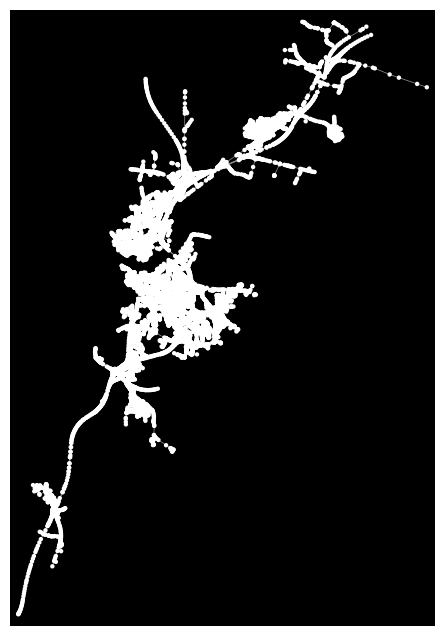

In [ ]:
# Visualize the projected graph
fig, ax = ox.plot_graph(G_proj, node_size=10, edge_linewidth=0.5, bgcolor='k')
plt.show()

In [ ]:
ox.save_graphml(G_proj, 'aalborg_nodes_undirected_filtered_50_with_time_series.graphml')